In [1]:
!git clone https://github.com/jiyuuchc/cellcutter.git

Cloning into 'cellcutter'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 266 (delta 156), reused 222 (delta 115), pack-reused 0
Receiving objects: 100% (266/266), 60.43 MiB | 27.23 MiB/s, done.
Resolving deltas: 100% (156/156), done.


In [2]:
import sys
sys.path.append('cellcutter')

import time
from os.path import join

import numpy as np
from numpy.random import default_rng
np.set_printoptions(precision=4)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['image.cmap'] = 'gray'

import cellcutter
import cellcutter.utils

cellcutter/cellcutter/utils.py:15: UserWarning: PyMaxFlow not found. Some functions may not work.
  warn("PyMaxFlow not found. Some functions may not work.")


### Load some image data

(-0.5, 199.5, 199.5, -0.5)

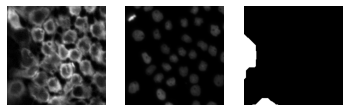

In [3]:
data = np.load('cellcutter/data/a1data.npz')
train_data = data['data']
input_img = train_data[...,0]
nucleus_img = train_data[..., 2]
mask_img = train_data[...,4]

# check the images
fig, ax = plt.subplots(1,3)
ax[0].imshow(input_img[100:300,200:400])
ax[0].axis('off')
ax[1].imshow(nucleus_img[100:300,200:400])
ax[1].axis('off')
ax[2].imshow(mask_img[100:300, 200:400])
ax[2].axis('off')

### Get the marker locations
We compute the marker locations from the the necleus image. 

Here we just use a simple blob detection algorithm, which works well enough for this demonstration. But you can get better results with algorithms that are dedicated to nucleus segmentation. 

/usr/local/lib/python3.7/dist-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/usr/local/lib/python3.7/dist-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/usr/local/lib/python3.7/dist-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/usr/local/lib/python3.7/dist-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/usr/local/lib/python3.7/dist-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/usr/local/lib/python3.7/dist-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma 

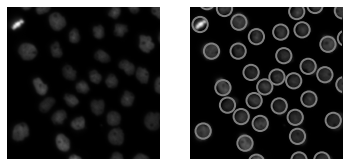

In [30]:
# Use a simple blob detection function
from cellcutter.markers import blob_detection
markers = blob_detection(nucleus_img, 10, 5, 0.1)

# check the result
xs, ys = markers.transpose()
label = np.zeros(shape = nucleus_img.shape, dtype=int)
label[(xs,ys)] = 1
fig, ax = plt.subplots(1,2)
ax[0].imshow(nucleus_img[100:300,200:400])
ax[0].axis('off')
ax[1].imshow(nucleus_img[100:300,200:400])
ax[1].axis('off')
for y,x in markers:
  y -= 100
  x -= 200
  c = plt.Circle((x, y), 10, color='gray', linewidth=2, fill=False)
  ax[1].add_patch(c)


### CNN segmentation

Here we train a CNN segmentation model on the fluorescence input. It will take a couple minutes.

In [31]:
dataset = cellcutter.Dataset(input_img, markers, mask_img = mask_img)

start = time.time()
model = cellcutter.UNet4(bn=True)
cellcutter.train_self_supervised(dataset, model, n_epochs = 30)

print('Elapsed time: %f'%(time.time() - start))

Epoch: 1 (32 steps) -- loss: 1828.711426
Epoch: 2 (64 steps) -- loss: 412.112549
Epoch: 3 (96 steps) -- loss: 32.117847
Epoch: 4 (128 steps) -- loss: -188.492218
Epoch: 5 (160 steps) -- loss: -247.975220
Epoch: 6 (192 steps) -- loss: -342.959381
Epoch: 7 (224 steps) -- loss: -416.514954
Epoch: 8 (256 steps) -- loss: -510.467102
Epoch: 9 (288 steps) -- loss: -609.794983
Epoch: 10 (320 steps) -- loss: -671.400330
Epoch: 11 (352 steps) -- loss: -742.487549
Epoch: 12 (384 steps) -- loss: -796.683044
Epoch: 13 (416 steps) -- loss: -820.606445
Epoch: 14 (448 steps) -- loss: -855.577759
Epoch: 15 (480 steps) -- loss: -879.762878
Epoch: 16 (512 steps) -- loss: -896.698425
Epoch: 17 (544 steps) -- loss: -905.767944
Epoch: 18 (576 steps) -- loss: -904.729797
Epoch: 19 (608 steps) -- loss: -899.125854
Epoch: 20 (640 steps) -- loss: -908.511963
Epoch: 21 (672 steps) -- loss: -944.409973
Epoch: 22 (704 steps) -- loss: -955.314026
Epoch: 23 (736 steps) -- loss: -974.681030
Epoch: 24 (768 steps) -- l

### Check the segmentation results

(-0.5, 199.5, 199.5, -0.5)

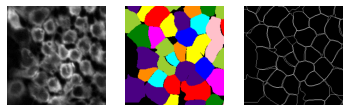

In [34]:
from skimage.color import label2rgb

label = cellcutter.utils.draw_label(dataset, model, np.zeros_like(input_img, dtype=int))
rgb = label2rgb(label, bg_label = 0)
border = cellcutter.utils.draw_border(dataset, model, np.zeros_like(input_img, dtype=int))
fig, ax = plt.subplots(1,3)
ax[0].imshow(input_img[100:300,200:400])
ax[0].axis('off')
ax[1].imshow(rgb[100:300,200:400])
ax[1].axis('off')
ax[2].imshow(border[100:300,200:400])
ax[2].axis('off')
